In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from wordcloud import WordCloud, STOPWORDS 
import textwrap
import string
import warnings
warnings.simplefilter('ignore')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
imdb_movies = pd.read_csv('imdb_movies_IND.csv')

imdb_movies.head()

,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,...,actors,description,avg_vote,votes,budget,usa_gross_income,worldwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,439,tt0016240,Prem Sanyas,Prem Sanyas,1925,1926-02-04,Drama,97,"India, Germany",NaN,...,"Seeta Devi, Himanshu Rai, Sarada Ukil, Ranibal...",This adaptation of Arnold's 1861 Orientalist e...,6.8,134,NaN,NaN,NaN,NaN,3.0,1.0
1,672,tt0019374,Shiraz,Shiraz,1928,1929-10-21,"Drama, History, Romance",97,"India, UK, Germany",NaN,...,"Himanshu Rai, Charu Roy, Seeta Devi, Enakashi ...",A historical romance set in the Mughal Empire....,7.0,229,NaN,NaN,16467.0,NaN,4.0,9.0
2,787,tt0020286,Prapancha Pash,Prapancha Pash,1929,2008,"Adventure, Drama, Romance",74,"UK, India, Germany",English,...,"Seeta Devi, Himanshu Rai, Charu Roy, Modhu Bos...",Two neighboring Indian kingdoms are ruled by c...,6.5,710,NaN,NaN,2306.0,NaN,8.0,14.0
3,1016,tt0021594,Alam Ara,Alam Ara,1931,1931-03-14,"Drama, Fantasy",124,India,"Hindi, Urdu",...,"Master Vithal, Zubeida, Jillo, Sushila, Prithv...",A period fantasy that told of the ageing king ...,6.3,106,NaN,NaN,NaN,NaN,NaN,1.0
4,2308,tt0027256,Achhut Kanya,Achhut Kanya,1936,1936,"Drama, Musical, Romance",142,India,"Hindi, Urdu",...,"Devika Rani, Ashok Kumar, Monorama, Pramila, K...","An ""untouchable"" girl and a Brahmin boy fall i...",6.5,104,NaN,NaN,NaN,NaN,2.0,1.0


In [3]:
imdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6373 entries, 0 to 6372
Data columns (total 23 columns):
Unnamed: 0                6373 non-null int64
imdb_title_id             6373 non-null object
title                     6373 non-null object
original_title            6373 non-null object
year                      6373 non-null int64
date_published            6373 non-null object
genre                     6373 non-null object
duration                  6373 non-null int64
country                   6373 non-null object
language                  6344 non-null object
director                  6360 non-null object
writer                    5740 non-null object
production_company        5639 non-null object
actors                    6373 non-null object
description               6292 non-null object
avg_vote                  6373 non-null float64
votes                     6373 non-null int64
budget                    1158 non-null float64
usa_gross_income          618 non-null float64
wo

# EDA

Text(0.5, 1.0, 'Distribution of Studio names')

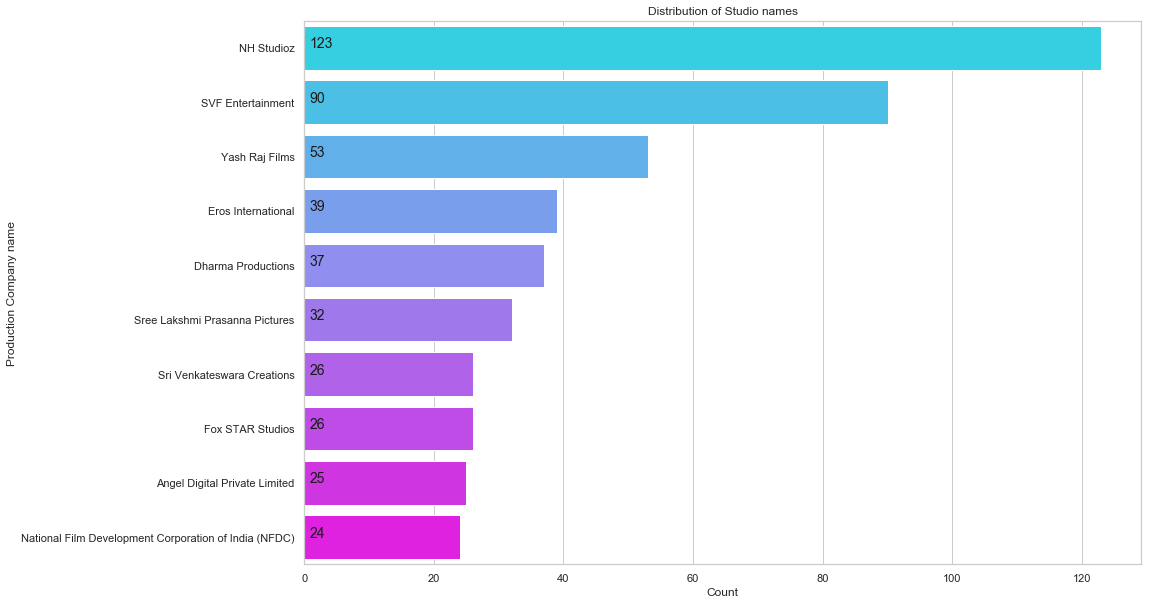

In [4]:
a = plt.cm.cool

plt.figure(figsize=(15,10))
count = imdb_movies['production_company'].value_counts()[:10]
sns.barplot(count.values, count.index, palette=[a(0.1),a(0.2),a(0.3),a(0.4),a(0.5),a(0.6),a(0.7),a(0.8),a(0.9),a(0.99)])
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=14)
plt.xlabel('Count')
plt.ylabel('Production Company name')
plt.title("Distribution of Studio names")

Text(0.5, 1.0, 'Distribution of Genres')

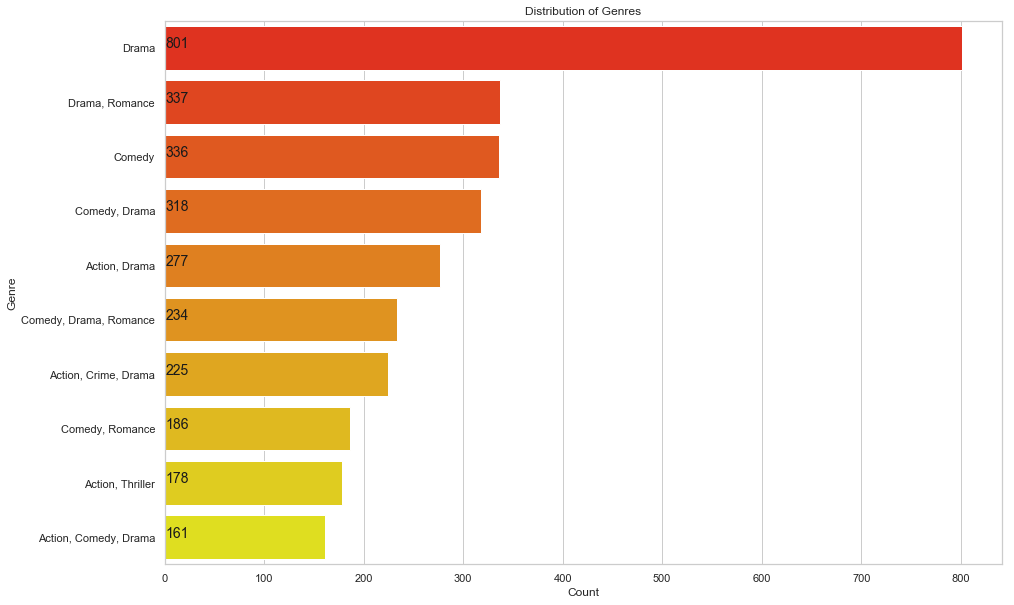

In [5]:
a = plt.cm.autumn

plt.figure(figsize=(15,10))
count = imdb_movies['genre'].value_counts()[:10]
sns.barplot(count.values, count.index, palette=[a(0.1),a(0.2),a(0.3),a(0.4),a(0.5),a(0.6),a(0.7),a(0.8),a(0.9),a(0.99)])
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=14)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title("Distribution of Genres")

In [6]:
num_data = ['duration', 'avg_vote', 'votes', 'budget', 'usa_gross_income', 'worldwide_gross_income', 
            'metascore', 'reviews_from_users', 'reviews_from_critics']
imdb_movies[num_data].describe()

,duration,avg_vote,votes,budget,usa_gross_income,worldwide_gross_income,metascore,reviews_from_users,reviews_from_critics
count,6373.000000,6373.000000,6373.000000,1.158000e+03,6.180000e+02,1.993000e+03,144.000000,5676.000000,4272.000000
mean,138.243214,6.216131,3449.462420,1.322012e+08,5.200459e+06,1.546427e+07,54.534722,31.713707,10.147004
std,23.074516,1.423553,18859.366095,3.200706e+08,2.448189e+07,7.537878e+07,16.052324,168.217414,32.058560
min,45.000000,1.000000,100.000000,0.000000e+00,1.416000e+03,4.200000e+01,17.000000,1.000000,1.000000
25%,123.000000,5.300000,213.000000,9.000000e+06,1.341840e+05,4.220400e+04,42.750000,3.000000,1.000000
50%,140.000000,6.500000,503.000000,4.000000e+07,4.845540e+05,2.432460e+05,55.000000,6.000000,3.000000
75%,153.000000,7.200000,1582.000000,1.395000e+08,1.431122e+06,1.574703e+06,66.000000,18.000000,9.000000
max,321.000000,9.900000,786365.000000,5.420000e+09,4.045402e+08,1.300000e+09,89.000000,7639.000000,582.000000


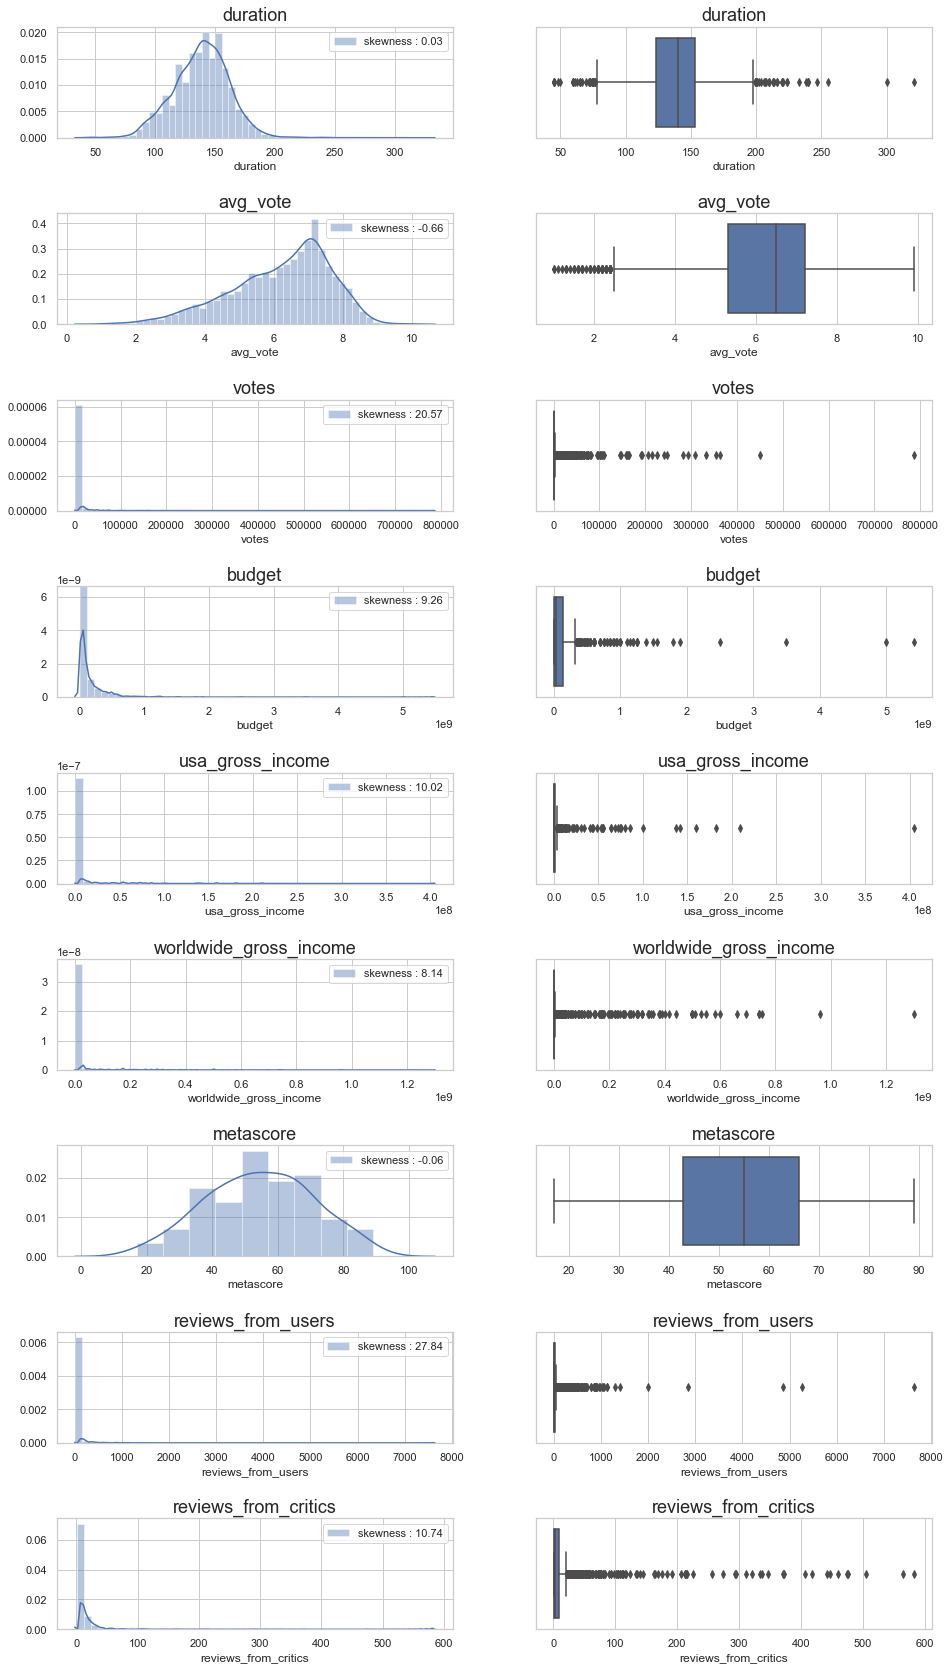

In [7]:
fig, ax = plt.subplots(9, 2, figsize = (14, 24))
fig.tight_layout(pad = 5)

for i, n in enumerate(num_data):
    sns.distplot(ax = ax[i,0], a = imdb_movies[n].dropna(), label = 'skewness : %.2f'%(imdb_movies[n].skew()))
    ax[i,0].set_title(n, fontsize = 18)
    ax[i,0].legend(loc = 'best')
    
    sns.boxplot(ax = ax[i, 1], x = imdb_movies[n].dropna())
    ax[i, 1].set_title(n, fontsize = 18)
plt.show()

In [8]:
imdb_movies['year'].replace('TV Movie 2019', 2019, inplace = True)
imdb_movies['year'] = imdb_movies['year'].astype(int)

# Group the data based on Decades
movies_by_decades = imdb_movies[['imdb_title_id', 'original_title', 'year','avg_vote', 'votes']]
decades = movies_by_decades['year']//10*10
decades = decades.astype(str)+' - '+ (decades+9).astype(str)
decades_column = pd.DataFrame(decades)
movies_by_decades.insert(3, 'decades', decades_column)
movies_by_decades.head()

,imdb_title_id,original_title,year,decades,avg_vote,votes
0,tt0016240,Prem Sanyas,1925,1920 - 1929,6.8,134
1,tt0019374,Shiraz,1928,1920 - 1929,7.0,229
2,tt0020286,Prapancha Pash,1929,1920 - 1929,6.5,710
3,tt0021594,Alam Ara,1931,1930 - 1939,6.3,106
4,tt0027256,Achhut Kanya,1936,1930 - 1939,6.5,104


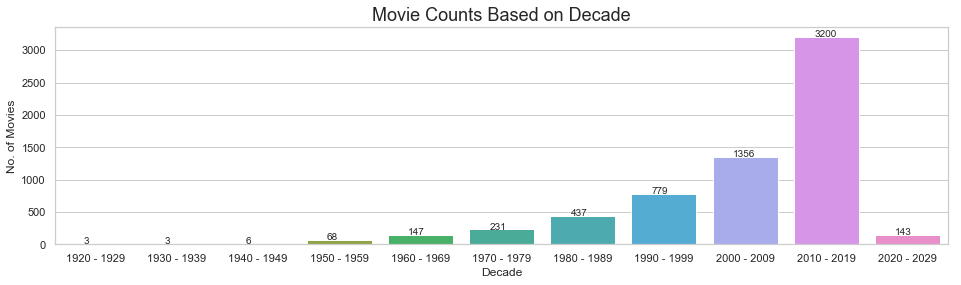

In [9]:
max_width = 15
fig, ax = plt.subplots(figsize = (16,4))
decades = movies_by_decades.groupby('decades')['imdb_title_id'].count().index
count = movies_by_decades.groupby('decades')['imdb_title_id'].count()
sns.barplot(ax = ax, x = decades, y = count)
ax.set_title('Movie Counts Based on Decade', fontsize = 18)
ax.set_xlabel('Decade')
for index,count in enumerate(count.astype(int)):
       ax.text(x=index-0.15 , y =count+1 , s=f"{count}" , fontdict=dict(fontsize=10))
ax.set_ylabel('No. of Movies')
plt.show()

In [10]:
imdb_movies['date_published'].replace('TV Movie 2019', 2019, inplace = True)
movies_published = imdb_movies[['imdb_title_id', 'original_title', 'genre', 'date_published','votes']]
movies_published['month_published'] = [month[5:7] for month in movies_published['date_published'].astype(str)]

#print(movies_published['month_published'].unique()) # There are blank values on month_published column
movies_published['month_published'][movies_published['month_published']==''] = np.nan # replace blank values with nan
movies_published.head()

,imdb_title_id,original_title,genre,date_published,votes,month_published
0,tt0016240,Prem Sanyas,Drama,1926-02-04,134,02
1,tt0019374,Shiraz,"Drama, History, Romance",1929-10-21,229,10
2,tt0020286,Prapancha Pash,"Adventure, Drama, Romance",2008,710,NaN
3,tt0021594,Alam Ara,"Drama, Fantasy",1931-03-14,106,03
4,tt0027256,Achhut Kanya,"Drama, Musical, Romance",1936,104,NaN


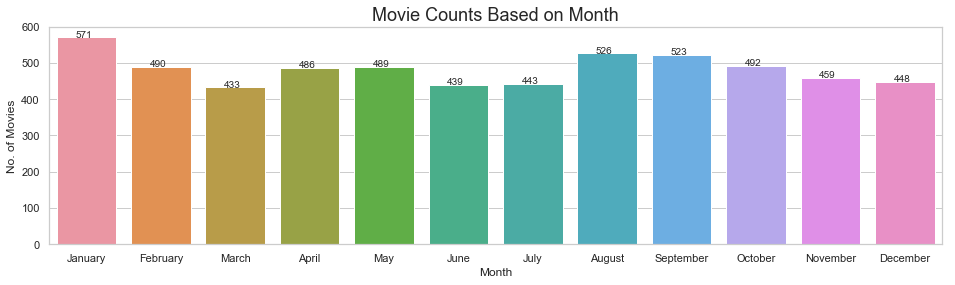

In [11]:
max_width = 15
fig, ax = plt.subplots(figsize = (16,4))
months_published = movies_published.groupby('month_published')['imdb_title_id'].count().index
count_movies = movies_published.groupby('month_published')['imdb_title_id'].count()
sns.barplot(ax = ax, x = months_published, y = count_movies)
ax.set_title('Movie Counts Based on Month', fontsize = 18)
ax.set_xlabel('Month')
ax.set_ylabel('No. of Movies')
for index,count_movies in enumerate(count_movies):
       ax.text(x=index-0.15 , y =count_movies+0 , s=f"{count_movies}" , fontdict=dict(fontsize=10))
ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June'
                    , 'July', 'August', 'September', 'October', 'November', 'December'])

plt.show()

## WORDCLOUD

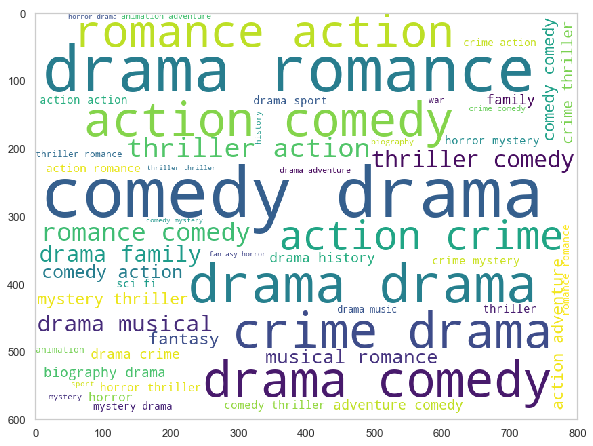

In [12]:
comment_words = ''
stop_words = set(STOPWORDS)

for val in imdb_movies['genre']:
    val = str(val)
    tokens = val.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 600, background_color = 'white'
                      , stopwords = stop_words, min_font_size = 10).generate(comment_words)

fig, ax = plt.subplots(figsize = (8, 6))
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
plt.show()

## Genres and Avg_Votes

In [13]:
movies_genre = imdb_movies[['imdb_title_id', 'original_title', 'genre', 'avg_vote']]
movies_genre['genre'] = movies_genre['genre'].astype('str')

genre_split = pd.DataFrame(movies_genre['genre'].str.split(',').tolist(), index=movies_genre['imdb_title_id']).stack()
genre_split = genre_split.reset_index(['imdb_title_id'])
genre_split.columns = ['imdb_title_id', 'genre_split']
movies_genre_split = pd.merge(genre_split, movies_genre[['imdb_title_id', 'original_title', 'avg_vote']],
                              left_on = 'imdb_title_id', right_on = 'imdb_title_id')
movies_genre_split['genre_split'] = movies_genre_split['genre_split'].str.lstrip(' ').str.rstrip(' ')
movies_genre_split.tail()

,imdb_title_id,genre_split,original_title,avg_vote
13592,tt9905412,Drama,Ottam,7.4
13593,tt9905462,Drama,Pengalila,8.8
13594,tt9906644,Comedy,Manoharam,6.8
13595,tt9906644,Drama,Manoharam,6.8
13596,tt9911774,Drama,Padmavyuhathile Abhimanyu,7.9


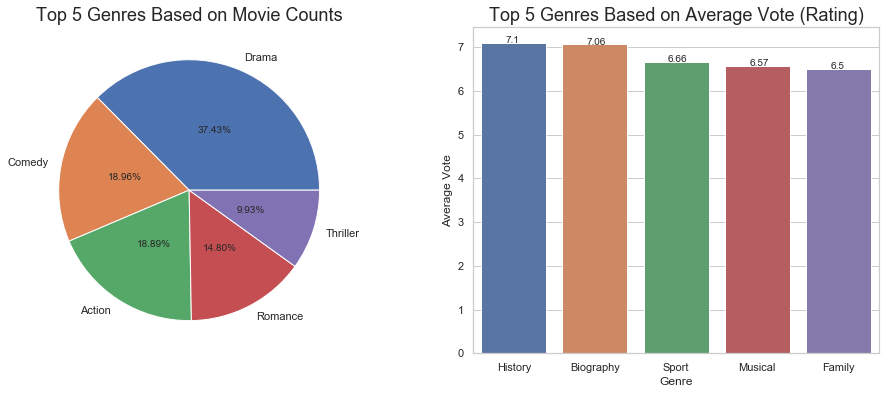

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (16,6))

genres = movies_genre_split.groupby('genre_split')['imdb_title_id'].count().sort_values(ascending = False).index[0:5]
count_movies = movies_genre_split.groupby('genre_split')['imdb_title_id'].count().sort_values(ascending = False)[0:5]
ax[0].pie(x=count_movies, autopct="%.2f%%", labels=genres, pctdistance=0.5)
ax[0].set_title('Top 5 Genres Based on Movie Counts', fontsize = 18)

genres = movies_genre_split.groupby('genre_split')['avg_vote'].mean().sort_values(ascending = False).index[0:5]
avg_votes = movies_genre_split.groupby('genre_split')['avg_vote'].mean().sort_values(ascending = False)[0:5]
sns.barplot(ax = ax[1], x = genres, y = avg_votes)
ax[1].set_title('Top 5 Genres Based on Average Vote (Rating)', fontsize = 18)
ax[1].set_xlabel('Genre')
for index,avg_votes in enumerate(round(avg_votes, 2)):
    ax[1].text(x=index-0.1 , y =avg_votes+0 , s=f"{avg_votes}" , fontdict=dict(fontsize=10))
ax[1].set_ylabel('Average Vote')


plt.show()

## DIRECTORS

In [15]:
movies_director = imdb_movies[['imdb_title_id', 'original_title', 'director', 'avg_vote']]
movies_director['director'] = movies_director['director'].astype('str')

director_split = pd.DataFrame(movies_director['director'].str.split(',').tolist(), index=movies_director['imdb_title_id']).stack()
director_split = director_split.reset_index(['imdb_title_id'])
director_split.columns = ['imdb_title_id', 'director_split']
movies_director_split = pd.merge(director_split, movies_director[['imdb_title_id', 'original_title', 'avg_vote']],
                              left_on = 'imdb_title_id', right_on = 'imdb_title_id')
movies_director_split['director_split'] = movies_director_split['director_split'].str.lstrip(' ').str.rstrip(' ')
gb_director = movies_director_split.groupby('director_split').agg({ 'imdb_title_id' : ['count'], 'avg_vote': ['mean']})
gb_director.drop(gb_director[gb_director.index == 'nan'].index, inplace = True)
gb_director.head()

,imdb_title_id,avg_vote
,count,mean
director_split,,
A. Balakrishnan,1,7.000000
A. Bhimsingh,8,6.925000
A. Jagadesh,1,3.600000
A. Karunakaran,9,6.577778
A. Mahadev,1,5.500000


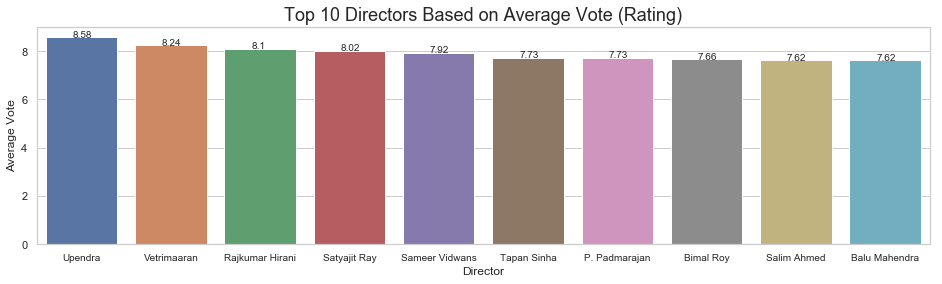

In [16]:
max_width = 15
fig, ax = plt.subplots(figsize = (16,4))

# Specification : at least have direct 5 movies
mask = movies_director_split.groupby('director_split')['imdb_title_id'].count() >= 5
directors = gb_director.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10].index
avg_vote = gb_director.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10]

sns.barplot(ax = ax, x = directors, y = avg_vote)
ax.set_title('Top 10 Directors Based on Average Vote (Rating)', fontsize = 18)
ax.set_xlabel('Director')
ax.set_xticklabels((textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels()), fontsize = 10)
for index,avg_vote in enumerate(round(avg_vote, 2)):
    ax.text(x=index-0.1 , y =avg_vote+0 , s=f"{avg_vote}" , fontdict=dict(fontsize=10))
ax.set_ylabel('Average Vote')

plt.show()

## WRITERS

In [17]:
movies_writer = imdb_movies[['imdb_title_id', 'original_title', 'writer', 'avg_vote']]
movies_writer['writer'] = movies_writer['writer'].astype('str')

writer_split = pd.DataFrame(movies_writer['writer'].str.split(',').tolist(), index=movies_writer['imdb_title_id']).stack()
writer_split = writer_split.reset_index(['imdb_title_id'])
writer_split.columns = ['imdb_title_id', 'writer_split']
movies_writer_split = pd.merge(writer_split, movies_writer[['imdb_title_id', 'original_title', 'avg_vote']],
                              left_on = 'imdb_title_id', right_on = 'imdb_title_id')
movies_writer_split['writer_split'] = movies_writer_split['writer_split'].str.lstrip(' ').str.rstrip(' ')
gb_writer = movies_writer_split.groupby('writer_split').agg({ 'imdb_title_id' : ['count'], 'avg_vote': ['mean']})
gb_writer.drop(gb_writer[gb_writer.index == 'nan'].index, inplace = True)
gb_writer.head()

,imdb_title_id,avg_vote
,count,mean
writer_split,,
A. Bhimsingh,4,6.975000
A. Deepakraj,3,5.766667
A. Jagadesh,1,3.600000
A. Karunakaran,9,6.322222
A. Mahadev,1,5.500000


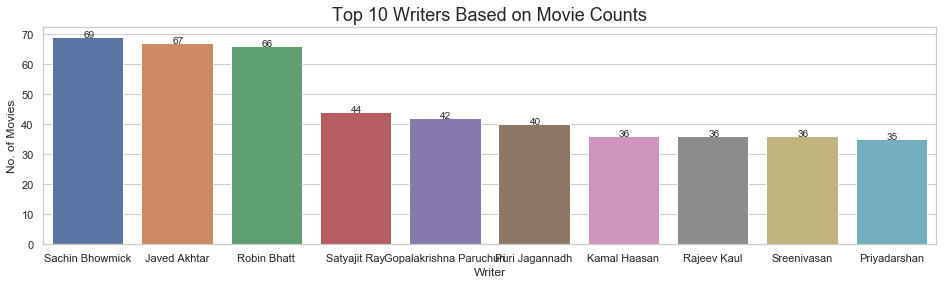

In [18]:
max_width = 15
fig, ax = plt.subplots(figsize = (16,4))

writers = gb_writer[('imdb_title_id', 'count')].sort_values(ascending = False)[0:10].index
count_movies = gb_writer[('imdb_title_id', 'count')].sort_values(ascending = False)[0:10]

sns.barplot(ax = ax, x = writers, y = count_movies)
ax.set_title('Top 10 Writers Based on Movie Counts', fontsize = 18)
ax.set_xlabel('Writer')
for index,count_movies in enumerate(count_movies):
    ax.text(x=index-0.05 , y =count_movies+0 , s=f"{count_movies}" , fontdict=dict(fontsize=10))
ax.set_ylabel('No. of Movies')

plt.show()

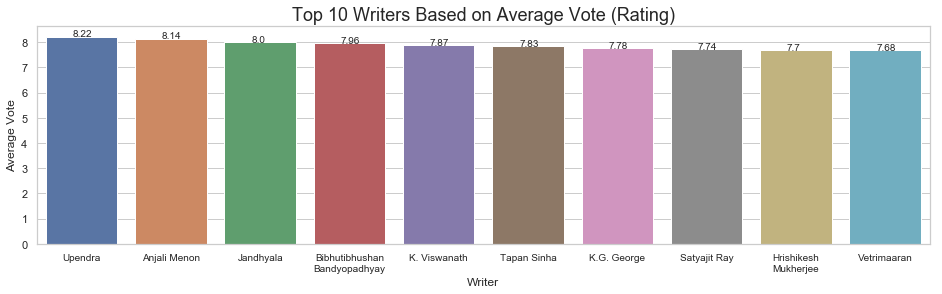

In [19]:
max_width = 15
fig, ax = plt.subplots(figsize = (16,4))

# Specification : at least have write 5 movies
mask = movies_writer_split.groupby('writer_split')['imdb_title_id'].count() >= 5
writers = gb_writer.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10].index
avg_vote = gb_writer.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10]

sns.barplot(ax = ax, x = writers, y = avg_vote)
ax.set_title('Top 10 Writers Based on Average Vote (Rating)', fontsize = 18)
ax.set_xlabel('Writer')
ax.set_xticklabels((textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels()), fontsize = 10)
for index,avg_vote in enumerate(round(avg_vote, 2)):
    ax.text(x=index-0.1 , y =avg_vote+0 , s=f"{avg_vote}" , fontdict=dict(fontsize=10))
ax.set_ylabel('Average Vote')

plt.show()

# PRODUCTION COMPANY

In [20]:
movies_productioncomp = imdb_movies[['imdb_title_id', 'original_title', 'production_company', 'avg_vote']]
movies_productioncomp['production_company'] = movies_productioncomp['production_company'].astype('str')

gb_productioncomp = movies_productioncomp.groupby('production_company').agg({ 'imdb_title_id' : ['count'], 'avg_vote': ['mean']})
gb_productioncomp.drop((gb_productioncomp[gb_productioncomp.index == ''].index) | (gb_productioncomp[gb_productioncomp.index == 'nan'].index), inplace = True)
gb_productioncomp.head()

,imdb_title_id,avg_vote
,count,mean
production_company,,
1-800-Love,1,6.2
1000 Lights Entertainments,1,6.1
100th Monkey Movies,1,7.3
11:11 Production,1,3.6
1234 Cine Creations,1,9.2


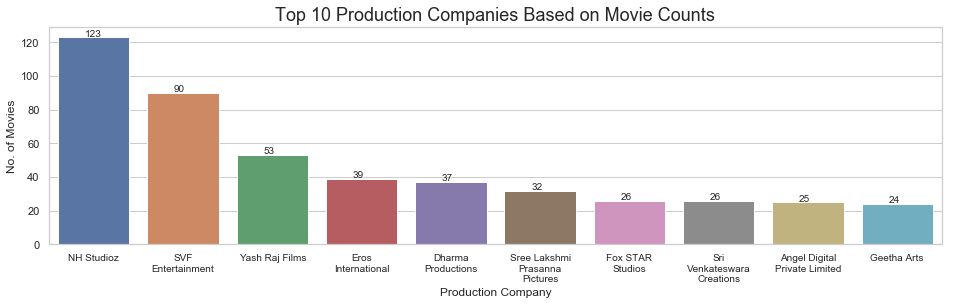

In [21]:
max_width = 15
fig, ax = plt.subplots(figsize = (16,4))

productioncomp = gb_productioncomp[('imdb_title_id', 'count')].sort_values(ascending = False)[0:10].index
count_movies = gb_productioncomp[('imdb_title_id', 'count')].sort_values(ascending = False)[0:10]

sns.barplot(ax = ax, x = productioncomp, y = count_movies)
ax.set_title('Top 10 Production Companies Based on Movie Counts', fontsize = 18)
ax.set_xlabel('Production Company')
ax.set_xticklabels((textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels()), fontsize = 10)
for index,count_movies in enumerate(count_movies):
    ax.text(x=index-0.1 , y =count_movies+0.6 , s=f"{count_movies}" , fontdict=dict(fontsize=10))
ax.set_ylabel('No. of Movies')
plt.show()

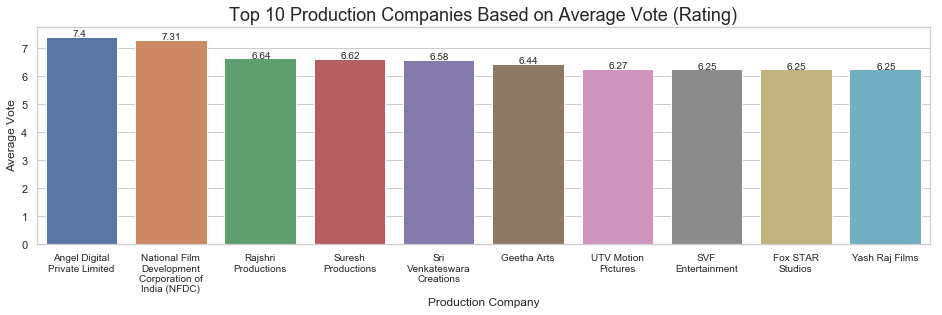

In [22]:
max_width = 15
fig, ax = plt.subplots(figsize = (16,4))

# Specification : at least have produce 20 movies
mask = movies_productioncomp.groupby('production_company')['imdb_title_id'].count() >= 20
productioncomp = gb_productioncomp.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10].index
avg_vote = gb_productioncomp.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10]

sns.barplot(ax = ax, x = productioncomp, y = avg_vote)
ax.set_title('Top 10 Production Companies Based on Average Vote (Rating)', fontsize = 18)
ax.set_xlabel('Production Company')
ax.set_xticklabels((textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels()), fontsize = 10)
for index,avg_vote in enumerate(round(avg_vote, 2)):
    ax.text(x=index-0.1 , y =avg_vote+0.005 , s=f"{avg_vote}" , fontdict=dict(fontsize=10))
ax.set_ylabel('Average Vote')

plt.show()

## ACTORS/ACTRESS

In [23]:
movies_actor = imdb_movies[['imdb_title_id', 'original_title', 'actors', 'avg_vote']]
movies_actor['actors'] = movies_actor['actors'].astype('str')

actor_split = pd.DataFrame(movies_actor['actors'].str.split(',').tolist(), index=movies_actor['imdb_title_id']).stack()
actor_split = actor_split.reset_index(['imdb_title_id'])
actor_split.columns = ['imdb_title_id', 'actor_split']
movies_actor_split = pd.merge(actor_split, movies_actor[['imdb_title_id', 'original_title', 'avg_vote']],
                              left_on = 'imdb_title_id', right_on = 'imdb_title_id')
movies_actor_split['actor_split'] = movies_actor_split['actor_split'].str.lstrip(' ').str.rstrip(' ')
gb_actor = movies_actor_split.groupby('actor_split').agg({ 'imdb_title_id' : ['count'], 'avg_vote': ['mean']})
gb_actor.drop((gb_actor[gb_actor.index == 'nan'].index), inplace = True)
gb_actor.head()

,imdb_title_id,avg_vote
,count,mean
actor_split,,
'Fatafat' Vijayalakshmi,1,8.300000
'Ganja' Karuppu,23,6.108696
'Nandha' Saravanan,3,6.700000
'Pizza' Venkatesh,2,7.050000
'Poo' Ram,5,7.020000


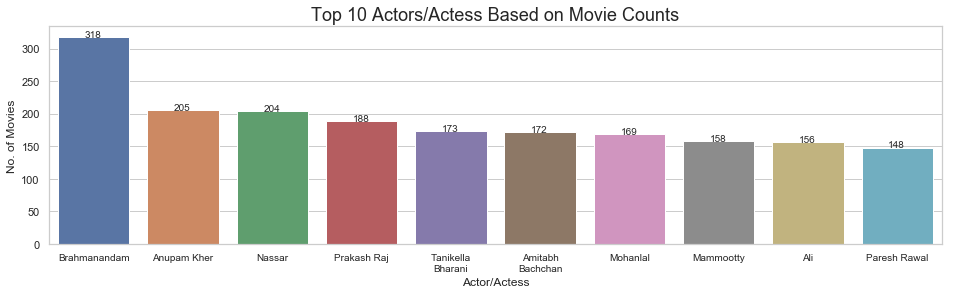

In [24]:
max_width = 15
fig, ax = plt.subplots(figsize = (16,4))

actor = gb_actor[('imdb_title_id', 'count')].sort_values(ascending = False)[0:10].index
count_movies = gb_actor[('imdb_title_id', 'count')].sort_values(ascending = False)[0:10]

sns.barplot(ax = ax, x = actor, y = count_movies)
ax.set_title('Top 10 Actors/Actess Based on Movie Counts', fontsize = 18)
ax.set_xlabel('Actor/Actess')
ax.set_xticklabels((textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels()), fontsize = 10)
for index,count_movies in enumerate(count_movies):
    ax.text(x=index-0.1 , y =count_movies+0 , s=f"{count_movies}" , fontdict=dict(fontsize=10))
ax.set_ylabel('No. of Movies')

plt.show()

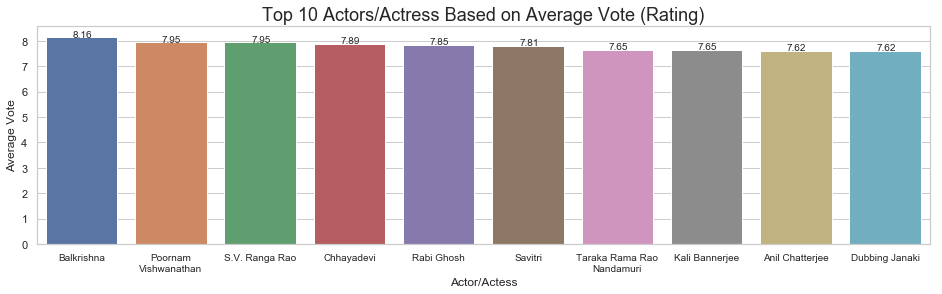

In [25]:
max_width = 15
fig, ax = plt.subplots(figsize = (16,4))

# Specification : at least have become an actor/actress on 10 movies
mask = movies_actor_split.groupby('actor_split')['imdb_title_id'].count() >= 10
actor = gb_actor.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10].index
avg_vote = gb_actor.loc[mask][('avg_vote',  'mean')].sort_values(ascending = False)[0:10]

sns.barplot(ax = ax, x = actor, y = avg_vote)
ax.set_title('Top 10 Actors/Actress Based on Average Vote (Rating)', fontsize = 18)
ax.set_xlabel('Actor/Actess')
ax.set_xticklabels((textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels()), fontsize = 10)
for index,avg_vote in enumerate(round(avg_vote, 2)):
    ax.text(x=index-0.1 , y =avg_vote+0.005 , s=f"{avg_vote}" , fontdict=dict(fontsize=10))
ax.set_ylabel('Average Vote')
plt.show()

# RECOMMENDATION SYSTEM USING COSINE SIMILARITY

In [26]:
data_recsys=imdb_movies[['original_title', 'genre', 'director', 'actors',
                         'description','writer',
                         'reviews_from_critics','reviews_from_users'
                         ]].reset_index(drop = True)
data_recsys.head()

,original_title,genre,director,actors,description,writer,reviews_from_critics,reviews_from_users
0,Prem Sanyas,Drama,"Franz Osten, Himanshu Rai","Seeta Devi, Himanshu Rai, Sarada Ukil, Ranibal...",This adaptation of Arnold's 1861 Orientalist e...,"Edwin Arnold, Niranjan Pal",1.0,3.0
1,Shiraz,"Drama, History, Romance",Franz Osten,"Himanshu Rai, Charu Roy, Seeta Devi, Enakashi ...",A historical romance set in the Mughal Empire....,"Niranjan Pal, William A. Burton",9.0,4.0
2,Prapancha Pash,"Adventure, Drama, Romance",Franz Osten,"Seeta Devi, Himanshu Rai, Charu Roy, Modhu Bos...",Two neighboring Indian kingdoms are ruled by c...,"Niranjan Pal, W.A. Burton",14.0,8.0
3,Alam Ara,"Drama, Fantasy",Ardeshir Irani,"Master Vithal, Zubeida, Jillo, Sushila, Prithv...",A period fantasy that told of the ageing king ...,"Joseph David, Joseph David",1.0,NaN
4,Achhut Kanya,"Drama, Musical, Romance",Franz Osten,"Devika Rani, Ashok Kumar, Monorama, Pramila, K...","An ""untouchable"" girl and a Brahmin boy fall i...","J.S. Casshyap, Niranjan Pal",1.0,2.0


In [27]:
data_recsys.set_index('original_title', inplace = True)

data_recsys['genre'] = data_recsys['genre'].fillna('').astype('str').str.lower()
data_recsys['genre'] = data_recsys['genre'].str.split(',')

data_recsys['director'] = data_recsys['director'].fillna('').astype('str').str.lower()
data_recsys['director'] = data_recsys['director'].str.split(',')

data_recsys['actors'] = data_recsys['actors'].fillna('').astype('str').str.lower()
data_recsys['actors'] = data_recsys['actors'].str.split(',')

data_recsys['writer'] = data_recsys['writer'].fillna('').astype('str').str.lower()
data_recsys['writer'] = data_recsys['writer'].str.split(',')

data_recsys['reviews_from_critics'] = data_recsys['reviews_from_critics'].fillna('').astype('str').str.lower()
data_recsys['reviews_from_critics'] = data_recsys['reviews_from_critics'].str.split(',')

data_recsys['reviews_from_users'] = data_recsys['reviews_from_users'].fillna('').astype('str').str.lower()
data_recsys['reviews_from_users'] = data_recsys['reviews_from_users'].str.split(',')

data_recsys['description'] = data_recsys['description'].fillna('').astype('str').str.lower()
data_recsys['description'] = data_recsys['description'].str.translate(str.maketrans('', '', string.punctuation))

In [28]:
listStopwords = set(stopwords.words('english'))
filtered = []
ps = PorterStemmer() 
for i, text in enumerate(data_recsys['description'].str.split()):
    for word in text:
        # Filtering/Removing stopwords in the text
        if word not in listStopwords:
            # Stemming words
            word_stemmed = ps.stem(word)
            filtered.append(word_stemmed)
    data_recsys['description'][i] = filtered
    filtered = []

In [29]:
data_recsys['final_content'] = ''
for i, text in data_recsys.iterrows():
    words = ''
    for col in data_recsys.columns:
        words = words + ' '.join(text[col]) + ' '
    data_recsys['final_content'][i] = words

In [30]:
data_recsys.to_csv("Recommendation_System_IND.csv")

In [31]:
count = CountVectorizer()
count_matrix = count.fit_transform(data_recsys['final_content']).astype(np.uint8)

In [32]:
chunk_size = 500 
matrix_len = count_matrix.shape[0] 

def similarity_cosine(start, end):
    if end > matrix_len:
        end = matrix_len
    return cosine_similarity(X=count_matrix[start:end], Y=count_matrix)
cosine_similarity_all = []
i=0

In [33]:
for chunk_start in range(0, matrix_len, chunk_size):
    
    if i == 0: 
        cosine_sim = similarity_cosine(chunk_start, chunk_start+chunk_size)
    
    else :
        cosine_similarity_chunk= similarity_cosine(chunk_start, chunk_start+chunk_size)
        cosine_sim = np.concatenate((cosine_sim.astype(np.float32), cosine_similarity_chunk.astype(np.float32)))
    
    i= 1

In [34]:
index_movies = pd.Series(data_recsys.index)

# Movies Recommendation function
def get_movies(title, cosine_sim = cosine_sim):
    recommended_movies = []
    index_movie_input = index_movies[index_movies == title].index[0]
    score_movies = pd.Series(cosine_sim[index_movie_input]).sort_values(ascending = False)
    top_10_index_movies = list(score_movies.iloc[1:11].index)
    for i in top_10_index_movies:
        recommended_movies.append(imdb_movies['original_title'].iloc[i] + ' (' + str(imdb_movies['year'].iloc[i]) + ')')
    return recommended_movies

In [35]:
get_movies('Zindagi Na Milegi Dobara')

['Luck by Chance (2009)',
 'Don 2 (2011)',
 'Dil Dhadakne Do (2015)',
 'Bombay Talkies (2013)',
 'Lakshya (2004)',
 'Rock On!! (2008)',
 'Dil Chahta Hai (2001)',
 'Gully Boy (2019)',
 'Albert Pinto Ko Gussa Kyon Ata Hai (1980)',
 'Naseem (1995)']